In [1]:
from pandas_datareader.data import DataReader
from pandas_datareader import wb
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

Determine the time range using explicit dates

In [2]:
start=datetime.datetime(2020, 1, 27)
end=datetime.datetime(2024,7,7)

In [3]:
NVDA= DataReader("NVDA", 'stooq', start, end).iloc[::-1] 
CLSK=DataReader("CLSK", 'stooq', start, end).iloc[::-1] 
MARA=DataReader("MARA", 'stooq', start, end).iloc[::-1] 

In [4]:
CLSK.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-27,5.2900,5.2900,5.000,5.1054,8735
2020-01-28,5.1715,5.1715,4.842,4.8420,7098
2020-01-29,5.0000,5.0000,4.760,4.7893,13068
2020-01-30,4.8500,4.8799,4.610,4.6900,8427
2020-01-31,4.6000,5.0919,4.600,4.6500,8244


In [5]:
tickers='NVDA CLSK MARA'.split()
stocks=pd.concat([NVDA, CLSK, MARA],axis=1,keys=tickers)
stocks.columns.names = ['Stock Ticker','Stock Info']
stocks

Stock Ticker       NVDA                                                 \
Stock Info         Open       High        Low      Close        Volume   
Date                                                                     
2020-01-27      5.93265    6.03274    5.78274    5.98148  4.723950e+08   
2020-01-28      6.04740    6.20731    5.99428    6.17484  3.122059e+08   
2020-01-29      6.16036    6.19663    6.07467    6.11462  2.604772e+08   
2020-01-30      6.01675    6.13479    5.96152    6.12121  2.916524e+08   
2020-01-31      6.07536    6.08735    5.84566    5.88749  3.718846e+08   
...                 ...        ...        ...        ...           ...   
2024-06-28    124.58000  127.71000  122.75000  123.54000  3.155167e+08   
2024-07-01    123.47000  124.84000  118.83000  124.30000  2.848855e+08   
2024-07-02    121.13000  123.41000  121.03000  122.67000  2.183740e+08   
2024-07-03    121.66000  128.28000  121.36000  128.28000  2.157490e+08   
2024-07-05    127.38000  128.85000  125.68000  125.83000  2.141767e+08   

Stock Ticker     CLSK                                       MARA           \
Stock Info       Open     High     Low    Close    Volume   Open     High   
Date                                                                        
2020-01-27     5.2900   5.2900   5.000   5.1054      8735   0.91   1.0000   
2020-01-28     5.1715   5.1715   4.842   4.8420      7098   0.97   1.1200   
2020-01-29     5.0000   5.0000   4.760   4.7893     13068   1.04   1.0400   
2020-01-30     4.8500   4.8799   4.610   4.6900      8427   0.99   1.1000   
2020-01-31     4.6000   5.0919   4.600   4.6500      8244   1.10   1.1000   
...               ...      ...     ...      ...       ...    ...      ...   
2024-06-28    16.2000  16.4550  15.730  15.9500  35723521  19.85  20.8100   
2024-07-01    16.4000  18.4200  16.260  17.9200  40486424  20.33  22.8393   
2024-07-02    17.9400  18.1400  16.915  16.9300  26646825  22.48  22.9800   
2024-07-03    16.5400  16.8079  15.920  16.1500  19266252  21.50  21.5798   
2024-07-05    15.4500  16.1300  15.120  16.0500  30904142  19.65  20.2350   

Stock Ticker                              
Stock Info        Low    Close    Volume  
Date                                      
2020-01-27     0.9100   0.9522    103080  
2020-01-28     0.9700   1.0100    510709  
2020-01-29     0.9700   0.9883     85163  
2020-01-30     0.9600   1.0700    238132  
2020-01-31     0.9905   1.0400    163452  
...               ...      ...       ...  
2024-06-28    19.4700  19.8500  49591032  
2024-07-01    20.3200  22.5600  74453651  
2024-07-02    21.5400  22.1200  47465145  
2024-07-03    20.6400  20.9800  30989025  
2024-07-05    19.4200  20.1700  40044604  

[1118 rows x 15 columns]

In [6]:
returns=pd.DataFrame()
for i in tickers:
    returns[i+' DailyReturn']=stocks[i]['Close'].pct_change()*100
returns.head()

,NVDA DailyReturn,CLSK DailyReturn,MARA DailyReturn
Date,,,
2020-01-27,NaN,NaN,NaN
2020-01-28,3.232645,-5.159243,6.070153
2020-01-29,-0.975248,-1.088393,-2.148515
2020-01-30,0.107774,-2.073372,8.266721
2020-01-31,-3.818199,-0.852878,-2.803738


In [7]:
returns.idxmin()

NVDA DailyReturn   2020-03-16
CLSK DailyReturn   2020-05-06
MARA DailyReturn   2021-11-15
dtype: datetime64[ns]

In [8]:
returns.idxmax()

NVDA DailyReturn   2023-05-25
CLSK DailyReturn   2020-05-05
MARA DailyReturn   2020-08-03
dtype: datetime64[ns]

In [9]:
returns.std()

NVDA DailyReturn    3.421783
CLSK DailyReturn    8.428749
MARA DailyReturn    9.010406
dtype: float64

In [10]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()

In [11]:
stocks.xs(key='Close',axis=1,level=1).iplot(kind="line",title='Close Price')

/opt/conda/lib/python3.10/site-packages/cufflinks/plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



In [12]:
window=20
stocks['NVDA','Rolling AVG']=NVDA['Close'].rolling(window).mean()
stocks['CLSK','Rolling AVG']=CLSK['Close'].rolling(window).mean()
stocks['MARA','Rolling AVG']=MARA['Close'].rolling(window).mean()

pd.concat([NVDA['Close'],CLSK['Close'],MARA['Close'],
           stocks['NVDA','Rolling AVG'],stocks['CLSK','Rolling AVG'],stocks['MARA','Rolling AVG']],axis=1,
          keys=('NVDA Close','CLSK Close','MARA Close',
                f'NVDA {window}day Avg',f'CLSK {window}day Avg',f'MARA {window}day Avg')).iplot()

/opt/conda/lib/python3.10/site-packages/cufflinks/plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



In [13]:
stocks['NVDA','Rolling STD']=NVDA['Close'].rolling(window).std()
stocks['CLSK','Rolling STD']=CLSK['Close'].rolling(window).std()
stocks['MARA','Rolling STD']=MARA['Close'].rolling(window).std()

pd.concat([stocks['NVDA','Rolling STD'],
           stocks['CLSK','Rolling STD'],
           stocks['MARA','Rolling STD']],axis=1,
          keys=(f'NVDA {window}day std',f'CLSK {window}day std',f'MARA {window}day std')).iplot(title='Volatility')

/opt/conda/lib/python3.10/site-packages/cufflinks/plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



Investigate a stock and forecast its close price using SARIMAX and Neural Networks

In [14]:
sto='NVDA'
qf = cf.QuantFig(stocks[sto],title=f'{sto} Bollinger Bands',legend='top',name=sto,up_color='green', down_color='red')
qf.add_bollinger_bands(periods=window, boll_std=2, colors=['#88511B','grey'], fill=True)
qf.add_volume(name='Volume',up_color='green', down_color='red')
qf.iplot()

/opt/conda/lib/python3.10/site-packages/cufflinks/plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.

/opt/conda/lib/python3.10/site-packages/cufflinks/plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.

/opt/conda/lib/python3.10/site-packages/cufflinks/quant_figure.py:1061: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [15]:
col=f'{sto} DailyReturn'

returns[col].iplot(kind='bar',layout=go.Layout(title=col,yaxis=dict(title="Return, %")))

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(stocks[sto,'Close'], model='multiplicative', period=365)

# Create DataFrames for each component
observed = decomposition.observed.to_frame(name='Observed')
trend = decomposition.trend.to_frame(name='Trend')
seasonal = decomposition.seasonal.to_frame(name='Seasonal')
residual = decomposition.resid.to_frame(name='Residual')

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual'))

fig.add_trace(go.Scatter(x=observed.index, y=observed['Observed'], name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=trend.index, y=trend['Trend'], name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=seasonal.index, y=seasonal['Seasonal'], name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=residual.index, y=residual['Residual'], name='Residual'), row=4, col=1)

# Update layout
fig.update_layout(height=800, width=900, title_text="Seasonal Decomposition of Time Series")
fig.show()

In [17]:
print(residual.info())
residual.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1118 entries, 2020-01-27 to 2024-07-05
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Residual  754 non-null    float64
dtypes: float64(1)
memory usage: 17.5 KB
None


Residual    364
dtype: int64

Evaluate the seasonality decomposition with autocorrelation test on 20 lags. If the pvalue is lower than alpha 0.05 it means that my decomposition model is not performing well. 

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Performing the Ljung-Box test for multiple lags
lags = np.arange(1, 21)
residual.dropna(inplace=True)
test_results = acorr_ljungbox(residual, lags=lags, return_df=True)
# Preparing the data for plotting
df = pd.DataFrame({'Lag': lags, 'P-value': test_results['lb_pvalue']})
# Creating the plot with cufflinks
df.iplot(kind='scatter', x='Lag', y='P-value', mode='lines+markers', title='Ljung-Box Test P-values',
         xTitle='Lag', yTitle='P-value', asFigure=True).add_shape(
    dict(type='line', x0=1, x1=20, y0=0.05, y1=0.05, line=dict(color='Red', dash='dash'))
).show()

Significant autocorrelation in residuals suggests that the current model (seasonal decomposition) might not adequately capture all the variations in the data after accounting for seasonality and trend.

In [19]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
from pmdarima import auto_arima

# Perform auto SARIMAX model selection
auto_model = auto_arima(stocks[sto,'Close'].dropna(), exogenous=None, seasonal=True, m=12)

# Extract the orders from the auto ARIMA model
order = auto_model.order
seasonal_order = auto_model.seasonal_order

# Fit the SARIMAX model using the identified orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(stocks[sto, 'Close'], order=order, seasonal_order=seasonal_order)
results = model.fit()
print(results.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67723D+00    |proj g|=  1.47447D-01

At iterate    5    f=  1.62045D+00    |proj g|=  3.38459D-02

At iterate   10    f=  1.60736D+00    |proj g|=  4.25271D-03

At iterate   15    f=  1.60719D+00    |proj g|=  6.50062D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   6.501D-06   1.607D+00
  F =   1.6071941317211038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

Model Fit: The SARIMAX(2, 2, 1) model appears to **adequately capture the autocorrelation** in the data as indicated by the non-significant Ljung-Box test.

Normality Assumption: There is **evidence against the normality** assumption of residuals based on the Jarque-Bera test, suggesting potential issues with the model’s assumption about the distribution of errors.

Heteroskedasticity: Significant heteroskedasticity in residuals suggests that the model **may not fully account for changing variance over time**, which could impact the reliability of predictions.

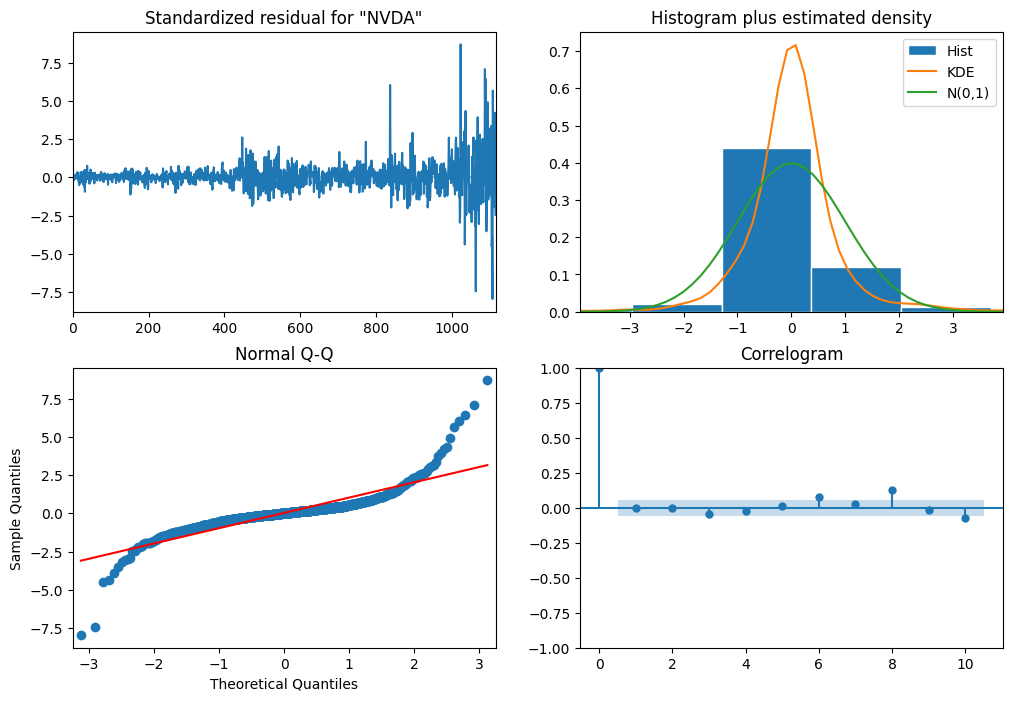

In [21]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

Residuals Plot:
Ideally, residuals should fluctuate around zero with no clear pattern or trend. Any systematic patterns might indicate that the model is missing some information or needs adjustment.

Autocorrelation Function (ACF) Plot:
Significant autocorrelation at certain lags suggests that the residuals are not independent. This could indicate that the model may benefit from including additional lagged terms or that the model order (p, q, P, Q) needs adjustment.

Histogram of Residuals:
Residuals should ideally follow a normal distribution centered around zero. Skewness or heavy tails in the histogram might suggest non-normality, indicating potential issues with the model’s assumptions or the need for a different error distribution.

QQ Plot (Quantile-Quantile Plot):
Points should approximately follow the diagonal line. Deviations from the line suggest departures from normality. Significant deviations might indicate that the residuals are not normally distributed, affecting the reliability of statistical inference.

If the residuals plot shows random scattering around zero, ACF plot shows no significant autocorrelation, histogram shows a bell-shaped curve, and QQ plot shows points close to the diagonal line, it indicates that the SARIMAX model adequately captures the patterns in the data.

In [22]:
# Define train and test size
train_size = int(len(stocks[sto, 'Close']) * 0.98)
train, test = stocks[sto, 'Close'][:train_size], stocks[sto, 'Close'][train_size:]

# Fit the SARIMAX model on training data
train_model = SARIMAX(train, order=(2, 2, 1), seasonal_order=(0, 0, 0, 0))
train_results = train_model.fit()

# Forecast the test data
forecast = train_results.get_forecast(steps=len(test))
forecasted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Set forecast index to match the test period
forecasted_values.index = test.index
confidence_intervals.index = test.index

# Plot forcast
pd.concat([train,test,forecasted_values],axis=1,keys=['Train','Test','Forcast']).iplot()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58051D+00    |proj g|=  1.15817D-01

At iterate    5    f=  1.50810D+00    |proj g|=  9.68212D-02

At iterate   10    f=  1.49682D+00    |proj g|=  2.67265D-03

At iterate   15    f=  1.49641D+00    |proj g|=  9.67231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   2.393D-06   1.496D+00
  F =   1.4964140330851852     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/opt/conda/lib/python3.10/site-packages/cufflinks/plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



In [23]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
# Calculate performance metrics
mae = round(mean_absolute_error(test, forecasted_values),3)
rmse = round(mean_squared_error(test, forecasted_values,squared=False),3)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 9.102
RMSE: 10.252


MAE (Mean Absolute Error): It represents the average absolute difference between the forecasted values and the actual values. A lower MAE indicates better accuracy.


RMSE (Root Mean Square Error): It represents the square root of the average squared differences between the forecasted values and the actual values. It gives more weight to larger errors. A lower RMSE also indicates better accuracy.

These values suggest that, on average, the model's predictions are off by around 9.102 units, and larger errors are penalized more heavily in the RMSE, with an average deviation of about 10.252 units.

In [24]:
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping

2024-07-16 19:37:29.714994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 19:37:29.715114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 19:37:29.847594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


use only the close price

In [25]:
data=pd.DataFrame(stocks[sto,'Close'].dropna())
print(data.shape)
data.head()

(1118, 1)


,NVDA
,Close
Date,
2020-01-27,5.98148
2020-01-28,6.17484
2020-01-29,6.11462
2020-01-30,6.12121
2020-01-31,5.88749


Creating sequences prepares the time series data in a format that LSTM model can effectively learn from, enabling accurate predictions of future values based on past observations. The observation window I chose is 60 days.

In [26]:
# Scale the data
scaler=MinMaxScaler() 
scaled_data = scaler.fit_transform(data)

# Define the training data length
train_data_len = int(np.ceil(len(scaled_data) * 0.8))

# Split the data into training and testing sets
train_data = scaled_data[:train_data_len, :]
test_data = scaled_data[train_data_len - 60:, :]

# Create the training data sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i, 0])
        labels.append(data[i, 0])
    return np.array(sequences), np.array(labels)

seq_length = 60

x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data to fit the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Build the Long-Short Term Memory (LSTM) Model

In [27]:
model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 3.4890e-04 - val_loss: 0.0015
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.1105e-04 - val_loss: 0.0015
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.3646e-04 - val_loss: 0.0022
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.8021e-04 - val_loss: 0.0014
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.6090e-04 - val_loss: 0.0012
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.4516e-04 - val_loss: 0.0011
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.1707e-04 - val_loss: 0.0012
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.2997e-04 - val_loss: 9.9658e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.3458e-04 - val_loss: 0.0010
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.1784e-04 - val_loss: 8.9690e-04
Epoc

In [28]:
# Make predictions
pred_LSTM = model.predict(x_test)
pred_LSTM = scaler.inverse_transform(pred_LSTM)

# Calculate RMSE
rmse = round(mean_squared_error(y_test, pred_LSTM, squared=False),3)

print(f'Root Mean Squared Error: {rmse}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Root Mean Squared Error: 77.403


In [29]:
# Plot the data
train = stocks[sto]['Close'][:train_data_len]
valid = stocks[sto]['Close'][train_data_len:].copy() 
pred=pd.Series(pred_LSTM.flatten(),index=valid.index,name='Pred')
pd.concat([train, valid, pred] ,axis=1 ,keys=['Train','Valid','Predicted']).iplot()

/opt/conda/lib/python3.10/site-packages/cufflinks/plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



To conclude, my exploration into time-series analysis has been enlightening, particularly in understanding the complexities of stock market prediction. While SARIMAX models are commonly used for forecasting, I've realized their effectiveness can vary significantly depending on the presence of seasonal patterns, which stocks may not always exhibit clearly.

I suspect that certain stocks might align better with SARIMAX modeling than others due to their inherent seasonal behaviors and trends. Throughout this process, I've developed a preference for interactive cufflinks-plotly plots, especially when visualizing and analyzing stock market data.


It seems like the LSTM model may have learned too much from the training data, making its predictions less accurate when faced with new data (high RMSE of 75). To improve its forecasting ability, I could try using more diverse data, simplifying the model, and fine-tuning its settings. This might help it better understand the underlying trends and make more reliable predictions in the future.